An example using multiple classification methods on the MiniBooNE  dataset. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import roc_curve, classification_report, roc_auc_score, auc

plt.style.use(['bmh'])

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

#Read in the number of signal & background events from text file
mbsigback=pd.read_table("../Datasets/MiniBooNE_PID.txt", delimiter=r"\s+", nrows=1, header=None)
nsig=mbsigback[0][0]
nback=mbsigback[1][0]

#Read signal and background into their own pandas dataframes
mbsig=pd.read_table("../Datasets/MiniBooNE_PID.txt", delimiter=r"\s+", nrows=20000, skiprows=1, header=None)
mbback=pd.read_table("../Datasets/MiniBooNE_PID.txt", delimiter=r"\s+", nrows=20000, skiprows=1+nsig, header=None)

#Add class column to mbsig and mbback
mbsig[50] = pd.Series([0 for x in range(len(mbsig.index))], index=mbsig.index)
mbback[50] = pd.Series([1 for x in range(len(mbback.index))], index=mbback.index)

#Merge all the data back together
mball=pd.concat([mbsig,mbback]) 

#Clean default values from the dataset (remove entries with -999.00 in any field)
for col in mball:
    mball=mball[mball[col]!=-999.00]
    
#Normalize data
norm_cols = [i for i in range(50)]
mball[norm_cols] = mball[norm_cols].apply(lambda x: (x - x.mean()) / x.std())

#Scramble the order of entries
mball=mball.sample(frac=1)
N=mball.shape[0] #Number of entries

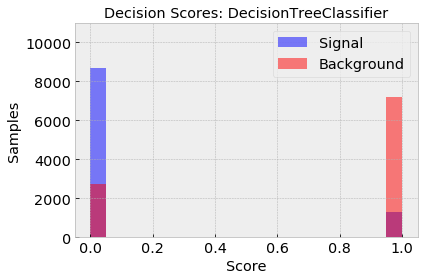

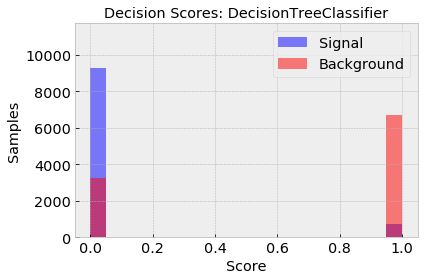

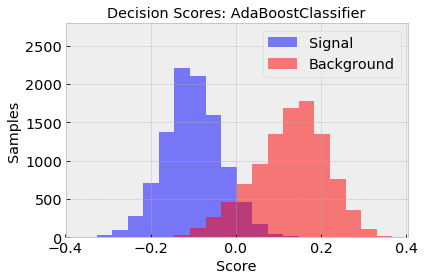

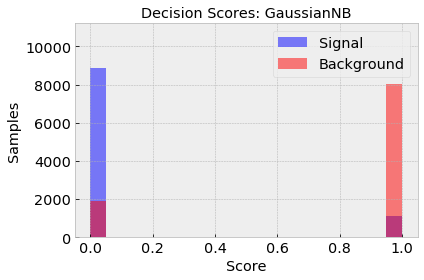

In [2]:
#Define and train models
models = [DecisionTreeClassifier(max_depth=1),
          DecisionTreeClassifier(max_depth=2),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=500),
          GaussianNB()]

#Form training and testing samples
test_fraction=0.5

#Training dataset
X=mball.iloc[0:int(N*test_fraction),0:49].values
y=mball.iloc[0:int(N*test_fraction),50].values

#Testing dataset
Xt=mball.iloc[int(N*test_fraction):N,0:49].values
yt=mball.iloc[int(N*test_fraction):N,50].values

class_names=("Signal","Background")
plot_colors = "br"
plot_step = 0.02

#Train the models
for model in models:
    model.fit(X,y)

    # Plot the two-class decision scores
    if hasattr(model,"decision_function"):
        twoclass_output = model.decision_function(X)
    else:
        twoclass_output = model.predict(X)
    plot_range = (twoclass_output.min(), twoclass_output.max())
    for i, n, c in zip(range(2), class_names, plot_colors):
        plt.hist(twoclass_output[y == i],
             bins=20,
             range=plot_range,
             facecolor=c,
             label=n,
             alpha=.5)
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, y1, y2 * 1.2))
    plt.legend(loc='upper right')
    plt.ylabel('Samples')
    plt.xlabel('Score')
    plt.title('Decision Scores: '+ model.__class__.__name__)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35)
    plt.show()

<b>Classification Report:</b>
<ul>
    <li>precision: ability of the classifier to not label as positive a sample that is negative (purity)
    <li>recall: ability of the classifier to find all the positive samples (efficiency)
    <li>f1-score: harmonic average of precision and recall
    <li>support: the true number of samples in this class
</ul>

In [3]:
for model in models:
    print("Classification report for",model.__class__.__name__)
    y_predicted = model.predict(Xt)
    print(classification_report(yt, y_predicted,
                            target_names=["Signal", "Background"]))

Classification report for DecisionTreeClassifier
              precision    recall  f1-score   support

      Signal       0.76      0.87      0.81      9986
  Background       0.85      0.72      0.78      9961

   micro avg       0.80      0.80      0.80     19947
   macro avg       0.80      0.80      0.80     19947
weighted avg       0.80      0.80      0.80     19947

Classification report for DecisionTreeClassifier
              precision    recall  f1-score   support

      Signal       0.73      0.93      0.82      9986
  Background       0.91      0.66      0.77      9961

   micro avg       0.80      0.80      0.80     19947
   macro avg       0.82      0.80      0.79     19947
weighted avg       0.82      0.80      0.79     19947

Classification report for AdaBoostClassifier
              precision    recall  f1-score   support

      Signal       0.91      0.91      0.91      9986
  Background       0.91      0.91      0.91      9961

   micro avg       0.91      0.91      

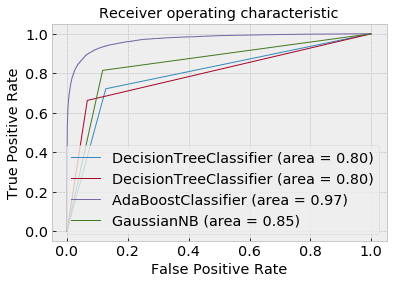

In [4]:
#Comparitive ROC Plot
#Get ROC for training sample
for model in models:
    if hasattr(model,"decision_function"):
        decisions = model.decision_function(Xt)
    else:
        decisions = model.predict(Xt)
    fpr, tpr, thresholds = roc_curve(yt, decisions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=model.__class__.__name__+' (area = %0.2f)'%(roc_auc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()